# Guided Test Case Generation System Notebook

In [58]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from sklearn.utils import shuffle

import joblib

### Read Data

In [59]:
def read_data(fpath) :
    df = pd.read_csv(fpath, sep=",", header=None)
    df.columns = ["sentence", "label"]
    df = shuffle(df)
    df = df.reset_index(drop=True)
    return df

df = {"alexa": read_data("training_data/alexa.txt"),
        "deepspeech": read_data("training_data/deepspeech.txt"),
        "gspeech": read_data("training_data/gspeech.txt"),
        "gcloud": read_data("training_data/gcloud.txt"),
        "wav2letter": read_data("training_data/wav2letter.txt"),
        "wit": read_data("training_data/wit.txt"),
        }

BUG_LABEL = 1
NON_BUG_LABEL = 0

In [60]:
df["deepspeech"].groupby("label").describe()

sentence                                                               
         count  unique                                               top freq
label                                                                        
0       179084  178271  not written in the book of the chronicles of the   11
1         1088    1088          she could only offer one solution it was    1

### Data distribution

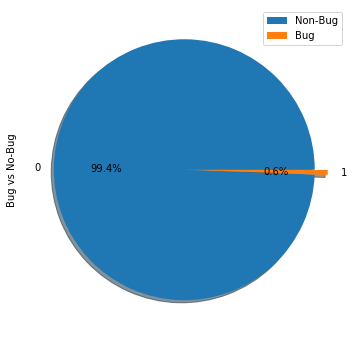

In [61]:
df["deepspeech"]["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Bug vs No-Bug")
plt.legend(["Non-Bug", "Bug"])
plt.show()

we need to handle imbalance data

### Handle Imbalance Data

Upsample the small data

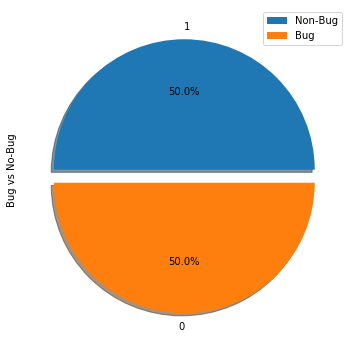

In [62]:
from sklearn.utils import resample

def upsampleImbalanceData(df):
    # Separate majority and minority classes
    df_majority = df[df.label==NON_BUG_LABEL]
    df_minority = df[df.label==BUG_LABEL]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    df_upsampled.label.value_counts()

    return df_upsampled.copy()

sample = upsampleImbalanceData(df["deepspeech"][:1000])
sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Bug vs No-Bug")
plt.legend(["Non-Bug", "Bug"])
plt.show()

### Feature Extraction

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import string

def remove_punctuation(sentence) :
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Text processing: remove punction
def text_process(sentence):
    nopunc =[char for char in sentence if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split()]

In [64]:
# bag of words
corpus_sentence = pd.read_csv('corpus-sentence.txt', sep=",", header=None)
corpus_sentence.columns = ["sentence"]
corpus_sentence["sentence"] = corpus_sentence["sentence"].apply(remove_punctuation)
# bow_transformer = CountVectorizer(analyzer=text_process).fit(corpus_sentence["sentence"])
bow_transformer = CountVectorizer(ngram_range=(1, 3)).fit(corpus_sentence["sentence"])

transformer = "model/transformer.sav"
joblib.dump(bow_transformer, transformer)

['model/transformer.sav']

In [65]:
def extract_feature(data) :
    return bow_transformer.transform(data)

## Experiment

### Trying Model in the First Batch

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [67]:
FIRST_BATCH_SIZE = 15000
BATCH_SIZE = 1000
MAX_SIZE = len(df["deepspeech"]["label"])

features = {}
labels = {}
for k,v in df.items() :
    data = v[:FIRST_BATCH_SIZE].copy()
    data = upsampleImbalanceData(data)
    features[k] = extract_feature(data["sentence"])
    labels[k] = data["label"]
# tfidf_transformer=TfidfTransformer().fit(sentence_bow)
# features = tfidf_transformer.transform(sentence_bow)

In [68]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=10)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=31, random_state=111)
bc = BaggingClassifier(n_estimators=10, random_state=111)
etc = ExtraTreesClassifier(n_estimators=10, random_state=111)

In [69]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}
# clfs = {'AdaBoost': abc}

In [70]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return (clf.predict(features))

In [71]:
from sklearn.base import clone as clone_model


models = {}
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "RF", "AdaBoost", "BgC", "ETC"]
selected_clfs = ["NB"]
for k in selected_clfs :
    per_sr_model = {}
    for key_sr in features.keys() :
        model = None
        model = clone_model(clfs[k])
        train_classifier(model, features[key_sr], labels[key_sr])
        per_sr_model[key_sr] = model
    models[k] = per_sr_model
    
for clf in models.keys() :
    for sr in models[clf].keys():
        filename = "model/" + clf + "_" + sr + ".sav"
        joblib.dump(models[clf][sr], filename)
    

### Trying Model for the Next Batch until Finish

In [72]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

MAX_SIZE = 20000


for key_clf, v in models.items() :
    print("Classifier: " + key_clf) 
    # classify the selected data
    training_data = {}
    for key_sr, model in v.items():
        training_data[key_sr] = df[key_sr][:FIRST_BATCH_SIZE].copy()

    lower_bound = FIRST_BATCH_SIZE

    columns = ["Predicted", "CorrectlyPredictedBug", "UndetectedBug", "Precision", "Recall", "F1"]
    index = []
    performance_data = []

    while (lower_bound < MAX_SIZE) :
        # set the upper bound size
        upper_bound = lower_bound + BATCH_SIZE
        if (upper_bound > MAX_SIZE) :
            upper_bound = MAX_SIZE
        batch = str(lower_bound) + " - " + str(upper_bound)
        index.append(batch)
            
        union_used_index = []
        union_bug_index = []
        bug_index_per_model = {}
            
        for key_sr, model in v.items():
            # get the data to be selected
            current_data = df[key_sr][lower_bound:upper_bound].copy()
            current_sentence = current_data["sentence"]
            current_labels = current_data["label"]

            # extract feature from the data
            current_features = extract_feature(current_sentence)

            # predict the current data
            pred = predict_labels(model, current_features)

            # see the classifier performance
            unused_index = np.where(pred == NON_BUG_LABEL)
            used_index = np.where(pred == BUG_LABEL)
            bug_index = np.where(current_labels == BUG_LABEL)
            non_bug_index = np.where(current_labels == NON_BUG_LABEL)
            
            union_used_index = list(set().union(union_used_index, used_index[0]))
            union_bug_index = list(set().union(union_bug_index, bug_index[0]))
            bug_index_per_model[key_sr] = bug_index[0]
            

        intersect = intersection(union_used_index, union_bug_index)
        intersection_length = len(intersect)
        undetected_bug = len(union_bug_index)-intersection_length
        precision = 0
        if (len(union_used_index) != 0) :
            precision = round(intersection_length/len(union_used_index), 2)
        recall = 0
        if ((intersection_length + undetected_bug) != 0) :
            recall = round(intersection_length/(intersection_length + undetected_bug), 2)
        precision_recall = precision + recall
        f1 = 0
        if precision_recall != 0 :
            f1 = round( 2 * precision * recall / (precision_recall), 2)
        performance_data.append([len(union_used_index), intersection_length, undetected_bug, precision, recall, f1])
        
        # add the predicted data to previous data
        if (len(union_used_index) > 0) :
            for key_sr, bug_index in bug_index_per_model.items() :
                intersection_index = intersection(union_used_index, bug_index)
                added_data = current_data.iloc[intersection_index,:]
                training_data[key_sr].append(added_data)

                # handle imbalance data
                training_data[key_sr] = upsampleImbalanceData(training_data[key_sr])

                # re-extract feature
                features[key_sr] = bow_transformer.transform(training_data[key_sr]["sentence"])
                labels[key_sr] = training_data[key_sr]["label"]

                # re-train the model 
                train_classifier(model, features[key_sr], labels[key_sr])

        # update the lower bound
        lower_bound = upper_bound

    performance = pd.DataFrame(performance_data, index=index, columns=columns)
    print(performance)
    generated = int(performance["Predicted"].sum(axis=0))
    bug = int(performance["CorrectlyPredictedBug"].sum(axis=0))
    undetected_bug =  int(performance["UndetectedBug"].sum(axis=0))
    precision = round(performance["Precision"].mean(), 2)
    recall = round(performance["Recall"].mean(), 2)
    f1 = round(performance["F1"].mean(), 2)
    print("Total Generated: " + str(generated))
    print("Total Bug: " + str(bug))
    print("Undetected Bug: " + str(undetected_bug))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1: " + str(f1))
    print("\n")
    

Classifier: NB
               Predicted  CorrectlyPredictedBug  UndetectedBug  Precision  \
15000 - 16000        248                     73             78       0.29   
16000 - 17000        217                     46             94       0.21   
17000 - 18000        226                     68             86       0.30   
18000 - 19000        242                     67             89       0.28   
19000 - 20000        232                     55             84       0.24   

               Recall    F1  
15000 - 16000    0.48  0.36  
16000 - 17000    0.33  0.26  
17000 - 18000    0.44  0.36  
18000 - 19000    0.43  0.34  
19000 - 20000    0.40  0.30  
Total Generated: 1165
Total Bug: 309
Undetected Bug: 431
Precision: 0.26
Recall: 0.42
F1: 0.32


